In [1]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langchain_groq import ChatGroq
import gradio as gr


/home/swana/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define Agents

StateGraph: The core of our application defining the flow of Travel Planner.
PlannerState: A custom type representing the state of our planning process.
 

In [2]:
class PlannerState(TypedDict):
    """State for the planner graph."""
    messages : Annotated[List[HumanMessage | AIMessage], "List of messages in the conversation."]
    """City to plan the trip to."""
    city : str
    """List of the places to visit."""
    interests : List[str]
    itinerary : str
    

Node Functions: Steps in the planning process

In [3]:
from Key import GROQ_API_KEY
llm = ChatGroq(
    # model="groq/llama-3.1-70b-chat",
    model = "llama-3.3-70b-versatile",
    temperature=0.1,
    max_tokens=1000,
    groq_api_key=GROQ_API_KEY,
)


In [4]:
from langchain.prompts import ChatPromptTemplate
itinerary_prompt = ChatPromptTemplate.from_messages([
    {
        "role": "system",
        "content": "You are a helpful assistant that plans trips. Create a trip itinerary for the {city} based on the user's {interests}. Also provide a brief description of each place, and suggest places to eat accordingly (lunch, dinner) in a bulleted itinerary."
    },
    {
        "role": "human",
        "content": "Plan a trip to {city} for the places I want to visit."
    }
])

Define agent funtions

In [5]:
def input_city(city: str, state: PlannerState) -> PlannerState:
    """Input the city to plan the trip to."""
    # user_message = input("Enter the city you want to plan a trip to: ")
    return {
        **state,
        "city": city,
        "messages" : state["messages"] + [HumanMessage(content=city)]
    }

In [6]:
def input_interest(interests: str, state: PlannerState) -> PlannerState:
    # user_message = input("Enter your interest for the trip to:(comma-separated): ")
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(",")],
        "messages" : state["messages"] + [HumanMessage(content=interests)]
    }

In [13]:
def create_itinerary(state: PlannerState) -> str:
    # print(f"Creating itinerary... Please wait. {state['city']} on given interests :{state['interests']}")
    response = llm.invoke(
        itinerary_prompt.format_messages(
            city=state["city"],
            interests=", ".join(state["interests"])
        )
    )
    # print("Itinerary created successfully!")
    # print(response.content)
    state["itinerary"] = response.content.split("\n")
    state["messages"].append(AIMessage(content=response.content))
    
    
    
    # Return the updated state with the itinerary
    # return {
    #     **state,
    #     "itinerary": response.content.split("\n"),
    #     "messages": state["messages"] + [AIMessage(content=response.content)]
    # }
    return response.content

In [14]:
workflow = StateGraph(PlannerState) \
    .add_node("input_city", input_city) \
    .add_node("input_interest", input_interest) \
    .add_node("create_itinerary", create_itinerary) \
    .set_entry_point("input_city") \
    # .set_end(END) 
    
workflow.add_edge("input_city", "input_interest") \
    .add_edge("input_interest", "create_itinerary")\
        .add_edge("create_itinerary", END)
        
app = workflow.compile()


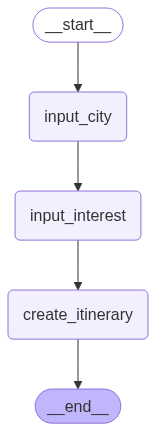

In [15]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
            # graph_style="default",
            # graph_name="Travel Planner Workflow"
        )
    )
)

###Function to run the graph


In [16]:
def create_planner_graph(city: str, interests: str):
    # """Create the planner graph."""
    # print(f"Initial request: {user_request}")
    state = {
        # "messages": [HumanMessage(content=user_request)],
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "", 
    }

    # for output in app.stream(state):
    #     pass
    state = input_city(city, state)
    state = input_interest(interests, state)
    itinerary = create_itinerary(state)
    return itinerary

In [17]:
# user_request = input("Enter your request for the trip planner: ")
# create_planner_graph(user_request) 

In [18]:
interface = gr.Interface(
    fn=create_planner_graph,
    inputs=[
        gr.Textbox(label="City", placeholder="Enter the city you want to plan a trip to"),
        gr.Textbox(label="Interests", placeholder="Enter your interests (comma-separated)"),
    ],
    outputs=[
        gr.Textbox(label="Itinerary", placeholder="Your trip itinerary will be displayed here"),
    ],
    title="Travel Planner",
    description="Plan your personlized trip by entering a city and your interests.",
    
)
interface.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
